In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [2]:
!pip install seaborn==0.13.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [45]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import textwrap
from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from src.utils import utils, evaluation_utils, visualization_utils

In [4]:
#tf_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240613/host_multi/few_shot_learning/fsl_non_idv_uniref90viridae_msl2048_transformer-l_6-h_8-d_1024-lr1e-4_classwise_auprc.csv")
# virprobert_80_20_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split70-10-20_virprobert_classwise_auprc.csv")
# virprobert_70_30_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split60-10-30_virprobert_classwise_auprc.csv")
# virprobert_50_50_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split40-10-50_virprobert_classwise_auprc.csv")
# virprobert_40_60_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240625/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_w3s5q-1_e25b32_msl2048_split30-10-60_virprobert_classwise_auprc.csv")

                                                 

virprobert_output_auprc_file_paths =  {
    "sl256st64_w5s5": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240911/host_multi/few_shot_learning/fsl_tr_w3s3q10_te_w3s3q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30cls_fnn_2l_d1024_lr1e-4_classwise_auprc.csv"),
    #"sl256st64_w5s2": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240906/host_multi/few_shot_learning/fsl_tr_w5s2q10_te_w5s2q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")
}
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_non_idv_lt_1_gte_0.05_prcnt_prevalence_seq_len_in_99prcntile.csv")

In [5]:
def read_output_df(output_file_paths):
    dfs = []
    for model, output_file_path in output_file_paths.items():
        df = pd.read_csv(output_file_path, index_col=0)
        df["model"] = model
        dfs.append(df)
    return pd.concat(dfs)


def compute_class_distribution(df, label_col, n, format=False):
    labels_counts = df[label_col].value_counts()
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k}\n({v:.2f}%)" for k, v, in labels_counts.items()}
    return labels_counts

In [6]:
df = read_output_df(virprobert_output_auprc_file_paths)
dataset_df = pd.read_csv(dataset_file_path)

In [7]:
dataset_df.shape

(11116, 12)

In [8]:
metadata_formatted = compute_class_distribution(dataset_df, "virus_host_name", n=47792, format=True)
metadata_formatted

{'Cyprinus carpio': 'Cyprinus carpio\n(0.86%)',
 'Petroica australis': 'Petroica australis\n(0.85%)',
 'Felis catus': 'Felis catus\n(0.62%)',
 'Gopherus morafkai': 'Gopherus morafkai\n(0.61%)',
 'Peromyscus boylii': 'Peromyscus boylii\n(0.59%)',
 'Marmota flaviventris': 'Marmota flaviventris\n(0.57%)',
 'Bos taurus': 'Bos taurus\n(0.54%)',
 'Eptesicus fuscus': 'Eptesicus fuscus\n(0.53%)',
 'Macaca mulatta': 'Macaca mulatta\n(0.49%)',
 'Loxodonta africana': 'Loxodonta africana\n(0.45%)',
 'Mastomys natalensis': 'Mastomys natalensis\n(0.43%)',
 'Gymnorhina tibicen': 'Gymnorhina tibicen\n(0.41%)',
 'Eidolon helvum': 'Eidolon helvum\n(0.38%)',
 'Sparus aurata': 'Sparus aurata\n(0.37%)',
 'Ailurus fulgens': 'Ailurus fulgens\n(0.36%)',
 'Elephas maximus': 'Elephas maximus\n(0.36%)',
 'Oryzomys sp.': 'Oryzomys sp.\n(0.33%)',
 'Lates calcarifer': 'Lates calcarifer\n(0.33%)',
 'Bufo bufo': 'Bufo bufo\n(0.32%)',
 'Crocodylus porosus': 'Crocodylus porosus\n(0.32%)',
 'Hypsugo savii': 'Hypsugo sav

In [9]:
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=47792, format=False)
metadata_unformatted

{'Cyprinus carpio': 0.8578841647137595,
 'Petroica australis': 0.8536993639102779,
 'Felis catus': 0.6214429193170405,
 'Gopherus morafkai': 0.610980917308336,
 'Peromyscus boylii': 0.5900569132909274,
 'Marmota flaviventris': 0.5670405088717777,
 'Bos taurus': 0.5356545028456646,
 'Eptesicus fuscus': 0.5314697020421828,
 'Macaca mulatta': 0.48543689320388345,
 'Loxodonta africana': 0.4456812855708068,
 'Mastomys natalensis': 0.4331268831603616,
 'Gymnorhina tibicen': 0.4059256779377301,
 'Eidolon helvum': 0.3766320723133579,
 'Sparus aurata': 0.36826247070639434,
 'Ailurus fulgens': 0.3640776699029126,
 'Elephas maximus': 0.35989286909943086,
 'Oryzomys sp.': 0.33478406427854035,
 'Lates calcarifer': 0.33059926347505864,
 'Bufo bufo': 0.3180448610646133,
 'Crocodylus porosus': 0.31595246066287247,
 'Hypsugo savii': 0.305490458654168,
 'Equus caballus': 0.305490458654168,
 'Dipodomys merriami': 0.30339805825242716,
 'Rattus norvegicus': 0.2950284566454637,
 'Crocodilurus amazonicus': 0

In [10]:
df["prevalence"] = df["class"].apply(lambda x: metadata_unformatted[x])
df.head()

,class,auprc,itr,model,prevalence
0,Grallina cyanoleuca,0.442786,0,sl256st64_w5s5,0.079511
1,Gymnorhina tibicen,0.920645,0,sl256st64_w5s5,0.405926
2,Luscinia cyanura,0.957174,0,sl256st64_w5s5,0.071142
3,Anas platyrhynchos,0.412908,0,sl256st64_w5s5,0.083696
4,Phrynocephalus theobaldi,0.509398,0,sl256st64_w5s5,0.052310


In [11]:
len(metadata_formatted)

143

In [12]:
classes = list(metadata_unformatted.keys())
classes

['Cyprinus carpio',
 'Petroica australis',
 'Felis catus',
 'Gopherus morafkai',
 'Peromyscus boylii',
 'Marmota flaviventris',
 'Bos taurus',
 'Eptesicus fuscus',
 'Macaca mulatta',
 'Loxodonta africana',
 'Mastomys natalensis',
 'Gymnorhina tibicen',
 'Eidolon helvum',
 'Sparus aurata',
 'Ailurus fulgens',
 'Elephas maximus',
 'Oryzomys sp.',
 'Lates calcarifer',
 'Bufo bufo',
 'Crocodylus porosus',
 'Hypsugo savii',
 'Equus caballus',
 'Dipodomys merriami',
 'Rattus norvegicus',
 'Crocodilurus amazonicus',
 'Tarsiger cyanurus',
 'Chelonia mydas',
 'Mus musculus',
 'Tursiops aduncus',
 'Rhinolophus ferrumequinum',
 'Ovis aries',
 'Tadarida brasiliensis',
 'Pteropus scapulatus',
 'Heloderma suspectum',
 'Anas superciliosa',
 'Squalius cephalus',
 'Oryctolagus cuniculus',
 'Coendou prehensilis',
 'Anas castanea',
 'Grus japonensis',
 'Amazona oratrix',
 'Callorhinus ursinus',
 'Phylloscopus inornatus',
 'Macaca fuscata',
 'Hoplobatrachus rugulosus',
 'Phrynocephalus erythrurus',
 'Mini

In [13]:
classes_order = {k:i for i, k in enumerate(classes)}
classes_order

{'Cyprinus carpio': 0,
 'Petroica australis': 1,
 'Felis catus': 2,
 'Gopherus morafkai': 3,
 'Peromyscus boylii': 4,
 'Marmota flaviventris': 5,
 'Bos taurus': 6,
 'Eptesicus fuscus': 7,
 'Macaca mulatta': 8,
 'Loxodonta africana': 9,
 'Mastomys natalensis': 10,
 'Gymnorhina tibicen': 11,
 'Eidolon helvum': 12,
 'Sparus aurata': 13,
 'Ailurus fulgens': 14,
 'Elephas maximus': 15,
 'Oryzomys sp.': 16,
 'Lates calcarifer': 17,
 'Bufo bufo': 18,
 'Crocodylus porosus': 19,
 'Hypsugo savii': 20,
 'Equus caballus': 21,
 'Dipodomys merriami': 22,
 'Rattus norvegicus': 23,
 'Crocodilurus amazonicus': 24,
 'Tarsiger cyanurus': 25,
 'Chelonia mydas': 26,
 'Mus musculus': 27,
 'Tursiops aduncus': 28,
 'Rhinolophus ferrumequinum': 29,
 'Ovis aries': 30,
 'Tadarida brasiliensis': 31,
 'Pteropus scapulatus': 32,
 'Heloderma suspectum': 33,
 'Anas superciliosa': 34,
 'Squalius cephalus': 35,
 'Oryctolagus cuniculus': 36,
 'Coendou prehensilis': 37,
 'Anas castanea': 38,
 'Grus japonensis': 39,
 'Ama

In [14]:
len(classes)

143

In [15]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

<Figure size 432x288 with 0 Axes>

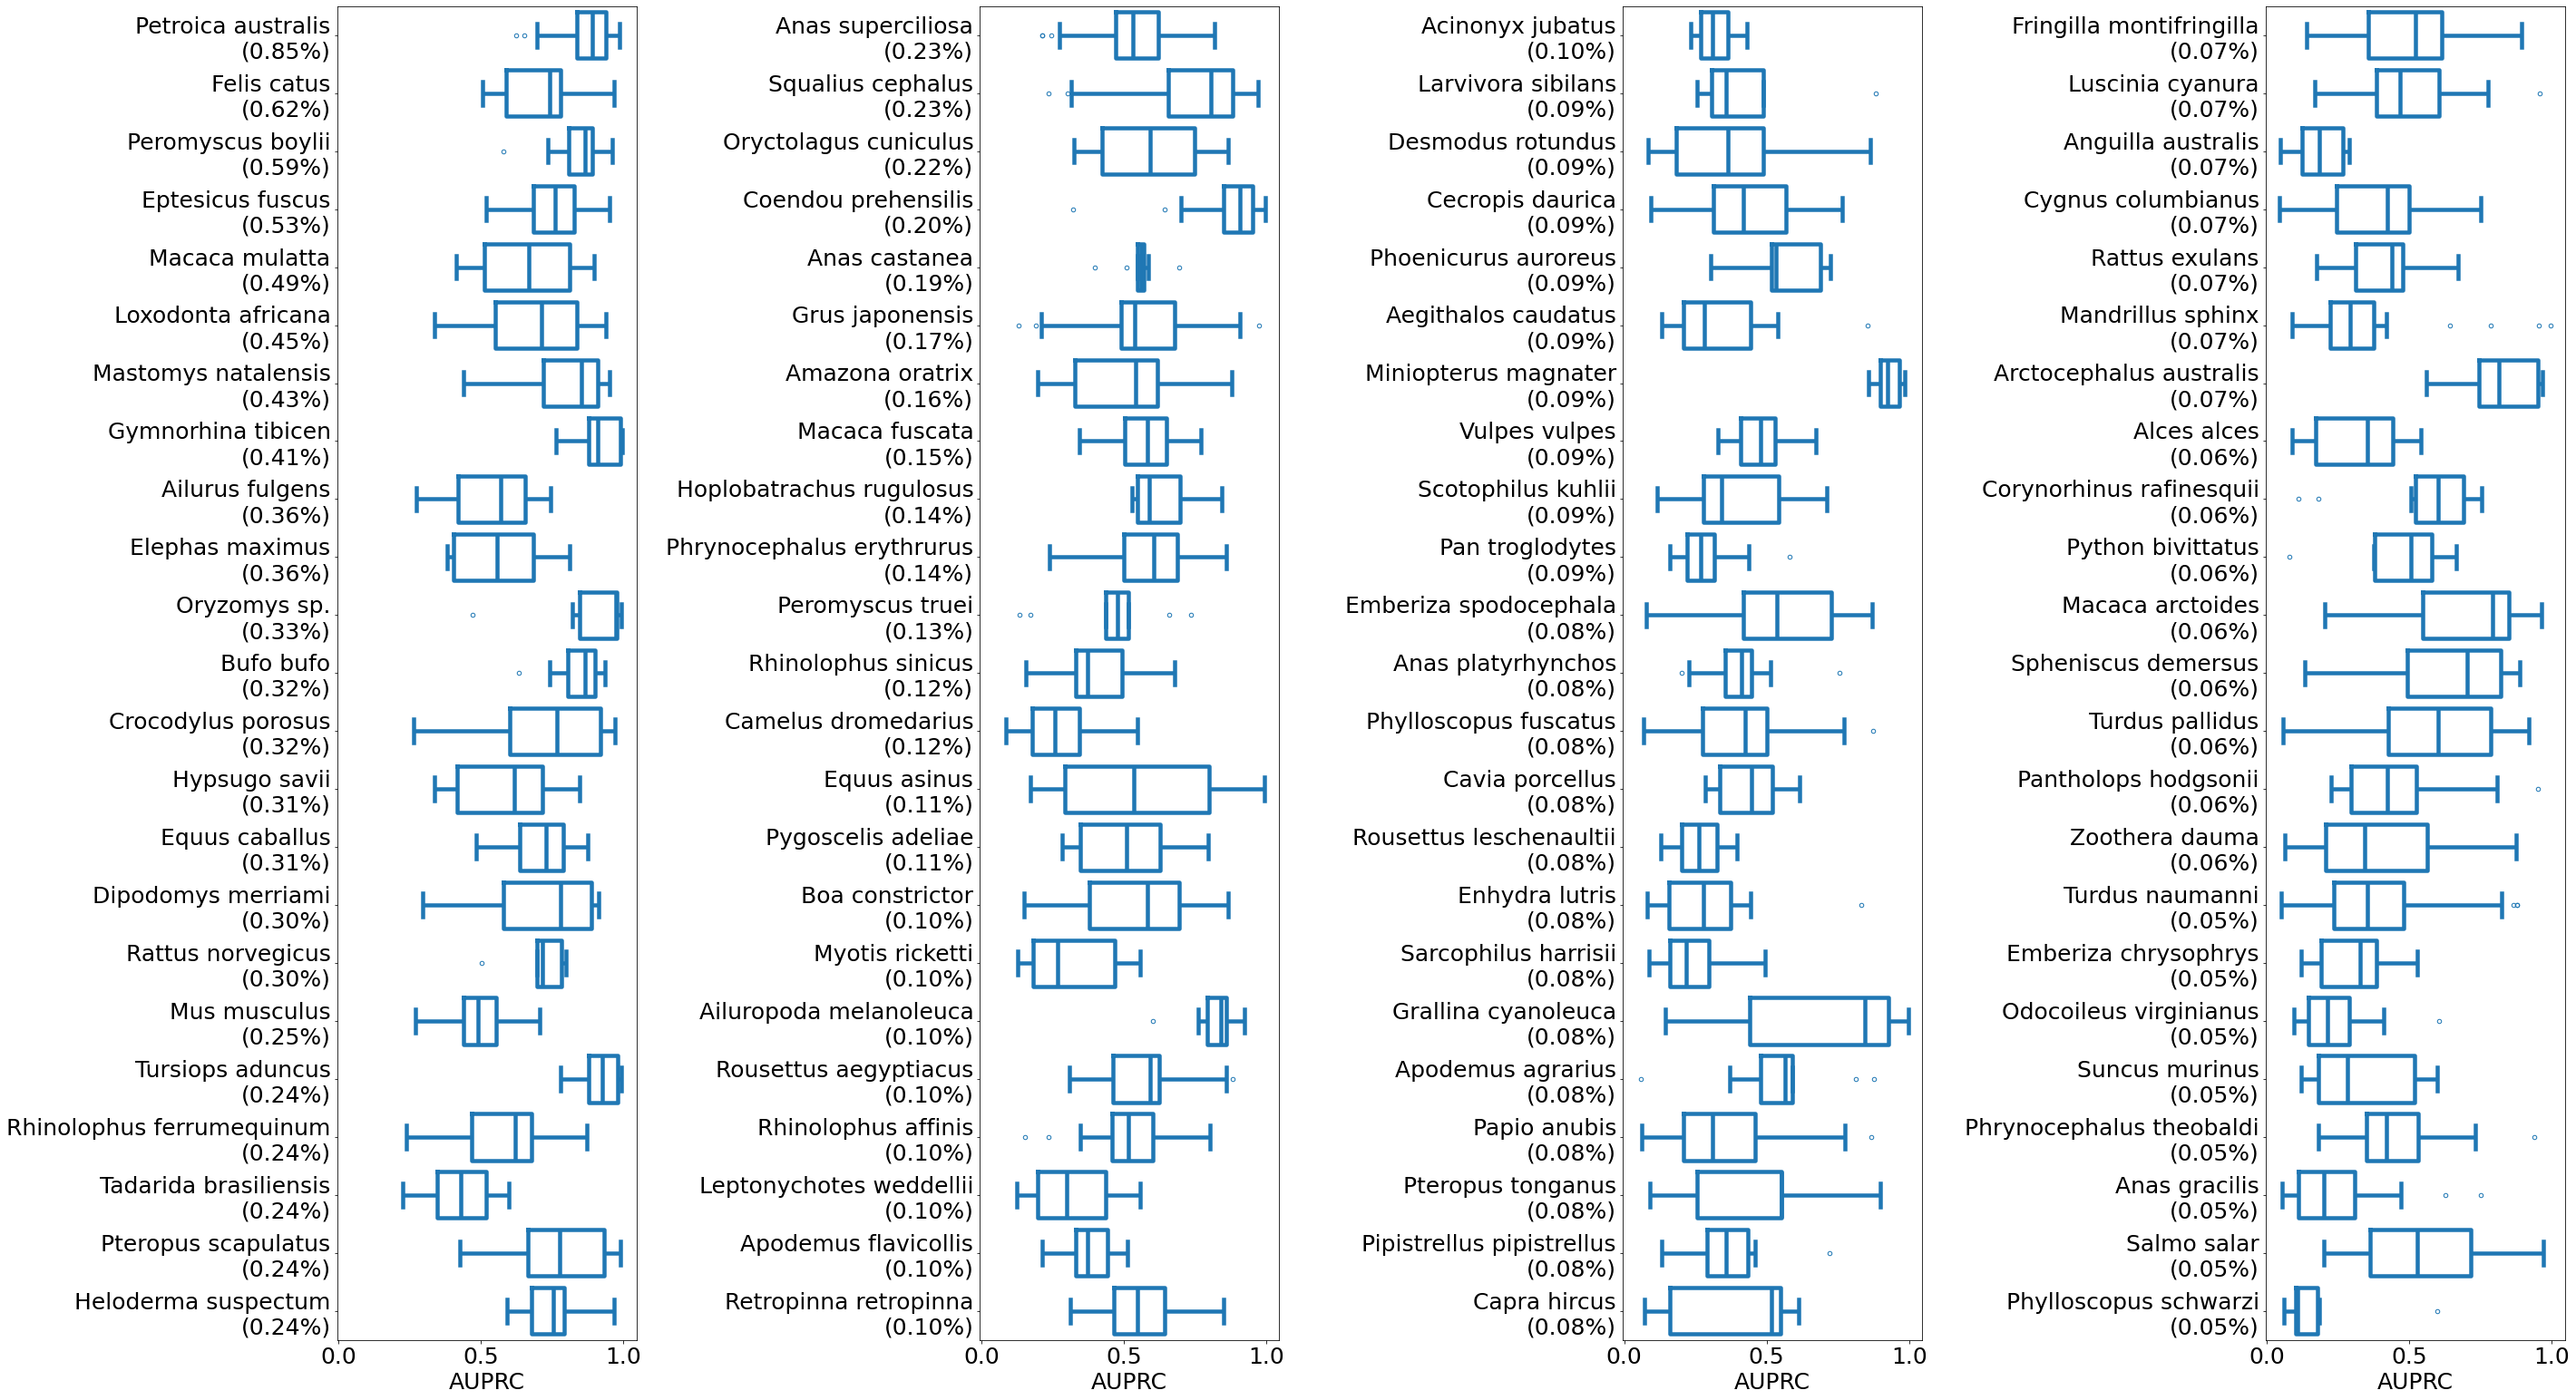

In [60]:
# plt.rcParams['xtick.labelsize'] = 15
# plt.rcParams['ytick.labelsize'] = 15



plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 4, figsize=(40, 22), sharex=True)
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams.update({'font.size': 25})

df.sort_values(by=["class"], key=lambda x: x.map(classes_order), inplace=True)
formatted_df = df.replace({"class": metadata_formatted})
classes = list(formatted_df["class"].unique())
bins = get_uniformly_divided_position_bins(list(classes), 4)
for i in range(4):
    #sns.violinplot(data=df[df["class"].isin(bins[i])],  x="auprc", y="class", hue="model", ax=axs[i], split=True, orient="h", linewidth=2.5, fill=False,  order=bins[i])
    sns.boxplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs[i], orient="h", linewidth=4.5, fill=False, fliersize=4.5, order=bins[i])
    
    #sns.stripplot(data=formatted_df[formatted_df["class"].isin(bins[i])], x="auprc", y="class", ax=axs[i], orient="h", color="black", order=bins[i])
    #plt.draw()

    axs[i].set_ylabel("")
    axs[i].set_xlabel("AUPRC")

plt.tight_layout(pad=.1)
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_non_idv_lt1_gte0.05_prcnt_classwise_boxplot_20240924.pdf"))
plt.show()

In [25]:
mean_auprc_df = df[["model", "class", "auprc"]].groupby(["model", "class"]).agg("mean").reset_index()
mean_auprc_df["prevalence"] = mean_auprc_df["class"].apply(lambda x: metadata_unformatted[x])
mean_auprc_df

,model,class,auprc,prevalence
0,sl256st64_w5s5,Acinonyx jubatus,0.320243,0.096250
1,sl256st64_w5s5,Aegithalos caudatus,0.336538,0.089973
2,sl256st64_w5s5,Ailuropoda melanoleuca,0.822992,0.104620
3,sl256st64_w5s5,Ailurus fulgens,0.533450,0.364078
4,sl256st64_w5s5,Alces alces,0.313596,0.064864
...,...,...,...,...
90,sl256st64_w5s5,Turdus pallidus,0.578034,0.056495
91,sl256st64_w5s5,Tursiops aduncus,0.918049,0.240626
92,sl256st64_w5s5,Tursiops truncatus,0.492981,0.050218
93,sl256st64_w5s5,Vulpes vulpes,0.482806,0.087881


<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

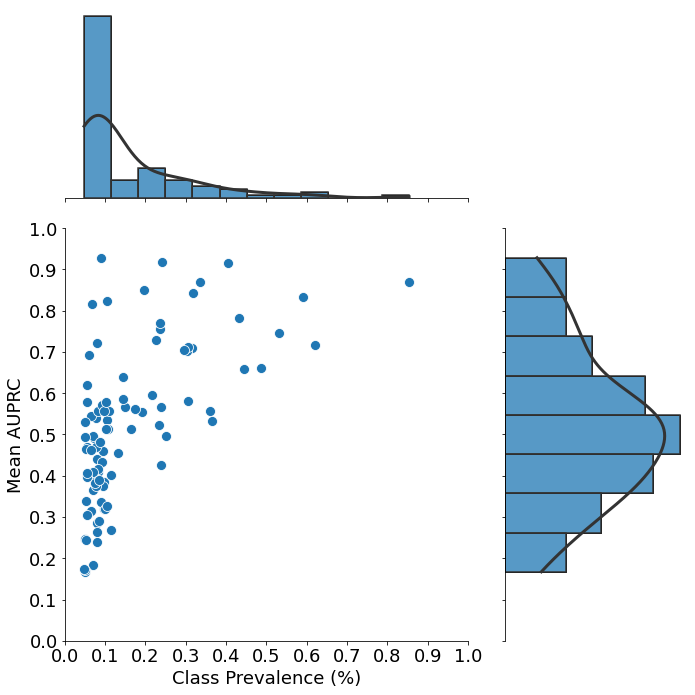

In [51]:
plt.clf()
plt.figure(figsize=(8,8))
plt.rcParams["figure.autolayout"] = True
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams.update({'font.size': 18})

ax = sns.jointplot(data=mean_auprc_df, x="prevalence", y="auprc",
                   height=10, ylim=(0, 1),  xlim=(0, 1),
                   ratio=2, legend=False)
ax.plot_joint(sns.scatterplot, alpha=1, s=100)
ax.plot_marginals(sns.histplot, kde=True, fill=False, color="0.2", line_kws={"color": "black", "lw": 3, "ls": "-"})
# ax = sns.scatterplot(mean_auprc_df, x="prevalance", y="auprc", hue="model", alpha=1)
ax.ax_joint.set_xlabel("Class Prevalence (%)")
ax.ax_joint.set_ylabel("Mean AUPRC")
ax.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.ax_joint.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.ax_joint.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax = plt.gca()
#ax.legend()
ax.figure.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_non_idv_lt1_gte0.05_prcnt_mean_auprc_scatterplot_w_hist_20240924.pdf"))
plt.show()